# Block 8: JAX

Wouldn't it be nice if we didn't have to do the derivative calculations manually? JAX is very similar to numpy, but it has a number of extra important capabilities, the most important of which is auto differentiation of arbitrary computations.

I had a difficult choice at this juncture: whether to introduce you to the more common `pytorch` library, or whether to use the less known `jax`. The first is widely used and somewhat similar to numpy, but introduces a number of new concepts. `jax` is actually faster, and I feel that introduces minimal changes which will hopefully be easier to appreciate within the short time span of this course.

In [67]:
import numpy as np 
import pandas as pd 
from typing import List
import jax.numpy as jnp 
import jax
import matplotlib.pyplot as plt

## Autodiff

In [60]:
# simple gradient
grad_fn = jax.grad(jax.numpy.sin)
grad_fn(0.)
grad_fn = jax.grad(jax.numpy.cos)
grad_fn(0.)

# gradient of a function that takes a parameter
def some_fn(w):
    return w * 2

grad_fn = jax.grad(some_fn)
grad_fn(4.)

# gradient of a function that takes a parameter + an input
def some_fn(w, x):
    return w*x

grad_fn = jax.grad(some_fn)
grad_fn(4., 10)

# gradient of a function that takes multiple parameters
def some_fn(p, x):
    return p['b0'] + p['b1'] * x 

grad_fn = jax.grad(some_fn)
grad_fn({ "b0" : 1., "b1" : 3.5 }, 10.) # neat! will return derivative with respect to b0 and with respect to b1


{'b0': Array(1., dtype=float32, weak_type=True),
 'b1': Array(10., dtype=float32, weak_type=True)}

## Randomness

JAX is explicit about random number generation. There is no magical "global" random number generator seed. Instead, any function that involves any kind of randomness, but receive a "key" that controls how the random numbers are generated.

In [61]:
key = jax.random.key(42)
print(jax.random.normal(key, 3)) # generate 3 standard normal values

print(jax.random.normal(key, 3)) # generate 3 standard normal values, because we are passing the same key, we get the same valeus

key, _ = jax.random.split(key, 2) # split into two new "child" keys ... we just use the first one
print(jax.random.normal(key, 3)) # generate 3 standard normal values, now the key is different so we get a diff value

# this doesn't work, it will keep generating same value
for i in range(10):
    val = jax.random.normal(key, 3)
    print(val)

print()
# a bit better but not ideal ...
key = jax.random.key(42)
for i in range(10):
    key, _ = jax.random.split(key)
    val = jax.random.normal(key, 3)
    print(val)

print()

# good solution
key = jax.random.key(42)
for i in range(10):
    loop_key = jax.random.fold_in(key, i)
    val = jax.random.normal(loop_key, 3)
    print(val)

[-0.02830462  0.46713185  0.29570296]
[-0.02830462  0.46713185  0.29570296]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]

[ 0.07592554 -0.48634264  1.2903206 ]
[-0.7197971  1.5521808 -0.8557356]
[ 1.5832745   0.06891013 -0.23817426]
[ 0.16889559 -1.978758   -1.169645  ]
[ 0.32114476  0.21683139 -0.9483882 ]
[-0.69533247  0.40693274  0.3515198 ]
[-1.0713949   0.20744139  1.0686921 ]
[-1.490867    0.15006733 -0.24445076]
[ 0.64465773 -1.0203602  -1.672845  ]
[1.1716218  0.42618108 0.23057559]

[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.60576403  0.7990441  -0.908927  ]
[ 0.4323065  0.5872638 -1.1416743]
[-0.2818947 -1.3674

# LinearModel with AutoDiff

In [62]:
def loss_fn(Beta, X, y):
    yhat = X @ Beta 
    mse = jnp.mean(jnp.square(yhat - y))
    return mse 

class LinearModel():

    def __init__(self, 
                 features: List[str]):
        self._features = features 
    
    def train(self, rng, df: pd.DataFrame, y: np.ndarray, steps: int = 100, eta: float = 0.01):

        # prepare inputs and outputs
        X = self._prepare_input_matrix(df[self._features])
        
        # randomly initialize solution 
        Beta = jax.random.normal(rng, X.shape[1]) # K

        # iterate for steps
        history = []
        for i in range(steps):
            mse = loss_fn(Beta, X, y)
            history.append([Beta, mse])

            # compute gradient
            # this is very powerful ... JAX takes care of derivative computation
            # so loss_fn could be as complex as you like
            Beta_grad = jax.grad(loss_fn)(Beta, X, y)
            
            # update solution
            Beta = Beta - eta * Beta_grad
        
        # save the parameters
        self._params, _ = history[-1]

        return history
    
    def _prepare_input_matrix(self, df: pd.DataFrame):

        # we need to separate categorical from numeric features
        # because they require separate processing
        # let's get categorical columns
        categorical_cols = df.select_dtypes(include='object').columns
        
        # let's get numeric
        ordinal_cols = df.select_dtypes(include='number').columns

        # construct input features
        X = df[ordinal_cols].to_numpy()

        # z-score (NxK' - 1xK') / 1xK' = NxK'
        X = (X - np.mean(X, axis=0)[None, :]) / np.std(X, axis=0)[None, :]

        # code categorical features
        for feature in categorical_cols:
            dummies = pd.get_dummies(df[feature]).to_numpy().astype(float)
            X = np.hstack((X, dummies)) 

        # add a column of ones
        ones_col = np.ones((X.shape[0], 1)) # Nx1
        X = np.hstack((ones_col, X)) # K
        
        return jnp.array(X) 
    
    def predict(self, df: pd.DataFrame):
         
        X = self._prepare_input_matrix(df[self._features])

        # compute model predictions
        yhat = X @ self._params # N

        return yhat 

In [63]:
# load dataset
df = pd.read_json('../data/cars.json')

# Filter dataframe
required_cols = ['Miles_per_Gallon', 'Cylinders', 'Displacement', 'Horsepower', 'Weight_in_lbs', 'Acceleration', 'Origin']

# only include rows where ALL columns are not nan
ix_included = np.sum(pd.isna(df[required_cols]), axis=1) == 0

# exclude examples with no horsepower or mpg
print("Before: ", df.shape)
df = df[ix_included]
print("After: ", df.shape)
df = df[required_cols]

Before:  (406, 9)
After:  (392, 9)


In [64]:
# Let's test the new class 
model = LinearModel(['Displacement', 'Origin', 'Cylinders', 'Horsepower'])
rng = jax.random.key(52345)

history = model.train(rng, df, df[ 'Miles_per_Gallon'].to_numpy())
print(history[-1][1])
yhat = model.predict(df)
mse = np.mean(np.square(yhat - df.Miles_per_Gallon))
print(mse)
print(jnp.array([h[1] for h in history]))


25.227446
25.227448
[502.9719   474.6761   448.10617  423.15173  399.71002  377.68518
 356.98804  337.5352   319.24896  302.05676  285.8908   270.68774
 256.38837  242.93726  230.28256  218.3758   207.17148  196.6271
 186.70279  177.36113  168.56714  160.28795  152.4927   145.15256
 138.24034  131.73056  125.59935  119.82422  114.38408  109.25913
 104.43077   99.88148   95.594826  91.55535   87.748566  84.16075
  80.77911   77.59155   74.586716  71.7539    69.083084  66.56477
  64.190094  61.950684  59.83864   57.846565  55.967457  54.19479
  52.52233   50.94429   49.455196  48.049873  46.72346   45.471416
  44.289402  43.173397  42.119564  41.124313  40.18426   39.296223
  38.457195  37.664352  36.915043  36.20674   35.53711   34.90389
  34.30502   33.738506  33.202503  32.695244  32.215088  31.760492
  31.32998   30.922186  30.535795  30.169598  29.822428  29.493214
  29.180918  28.884594  28.603315  28.336246  28.082563  27.841513
  27.61239   27.394506  27.187233  26.989962  26.802

## Non-Linear Model

Let's make a slight change to the model, so that it is non-linear:

$f(\mathbf{x}_{i})=\text{exp}(b_{0}+b_{1}x_{i1}+...)$

In [65]:
def loss_fn(Beta, X, y):
    yhat = X @ Beta 
    f = jnp.exp(yhat) # <-- that's the change
    mse = jnp.mean(jnp.square(f - y))
    return mse 

class NonLinearModel():

    def __init__(self, 
                 features: List[str]):
        self._features = features 
    
    def train(self, rng, df: pd.DataFrame, y: np.ndarray, steps: int = 100, eta: float = 0.01):

        # prepare inputs and outputs
        X = self._prepare_input_matrix(df[self._features])
        
        # randomly initialize solution 
        Beta = jax.random.normal(rng, X.shape[1]) # K

        # iterate for steps
        history = []
        for i in range(steps):
            mse = loss_fn(Beta, X, y)
            history.append([Beta, mse])

            # compute gradient
            # this is very powerful ... JAX takes care of derivative computation
            # so loss_fn could be as complex as you like
            Beta_grad = jax.grad(loss_fn)(Beta, X, y)
            
            # update solution
            Beta = Beta - eta * Beta_grad
        
        # save the parameters
        self._params, _ = history[-1]

        return history
    
    def _prepare_input_matrix(self, df: pd.DataFrame):

        # we need to separate categorical from numeric features
        # because they require separate processing
        # let's get categorical columns
        categorical_cols = df.select_dtypes(include='object').columns
        
        # let's get numeric
        ordinal_cols = df.select_dtypes(include='number').columns

        # construct input features
        X = df[ordinal_cols].to_numpy()

        # z-score (NxK' - 1xK') / 1xK' = NxK'
        X = (X - np.mean(X, axis=0)[None, :]) / (10 * np.std(X, axis=0)[None, :])

        # code categorical features
        for feature in categorical_cols:
            dummies = pd.get_dummies(df[feature]).to_numpy().astype(float)
            X = np.hstack((X, dummies)) 

        # add a column of ones
        ones_col = np.ones((X.shape[0], 1)) # Nx1
        X = np.hstack((ones_col, X)) # K
        
        return jnp.array(X) 
    
    def predict(self, df: pd.DataFrame):
         
        X = self._prepare_input_matrix(df[self._features])

        # compute model predictions
        yhat = X @ self._params # N
        f = jnp.exp(yhat)
        
        return f 

In [73]:
# Let's test the new class 
model = NonLinearModel(['Horsepower', 'Cylinders', 'Origin', 'Displacement'])

rng = jax.random.key(52345)

history = model.train(rng, df, df[ 'Miles_per_Gallon'].to_numpy(), eta=0.001)
print(history[-1][1])
yhat = model.predict(df)
mse = np.mean(np.square(yhat - df.Miles_per_Gallon))
print(mse)
print(jnp.array([h[1] for h in history]))


17.587074
17.587074
[259.01477  170.93886  112.49559   89.65775   72.42225   60.70168
  52.382122  45.728035  40.05024   35.290745  31.509916  28.700005
  26.740993  25.442797  24.604265  24.057995  23.68506   23.410263
  23.18977   22.999449  22.826538  22.66439   22.509638  22.360535
  22.216164  22.076025  21.939812  21.80734   21.678453  21.553038
  21.430967  21.312168  21.19653   21.08397   20.97439   20.867727
  20.76389   20.662785  20.564356  20.468512  20.375196  20.28433
  20.195833  20.10967   20.025757  19.944027  19.864431  19.786905
  19.711384  19.637825  19.566164  19.496367  19.428354  19.362097
  19.297548  19.234648  19.173355  19.113634  19.055431  18.998716
  18.943432  18.88956   18.837055  18.785872  18.735975  18.687346
  18.63994   18.593716  18.54865   18.504717  18.46187   18.420103
  18.37937   18.339645  18.300903  18.263126  18.226273  18.190334
  18.155281  18.121086  18.087725  18.05518   18.023428  17.992455
  17.96223   17.932743  17.90397   17.87589 

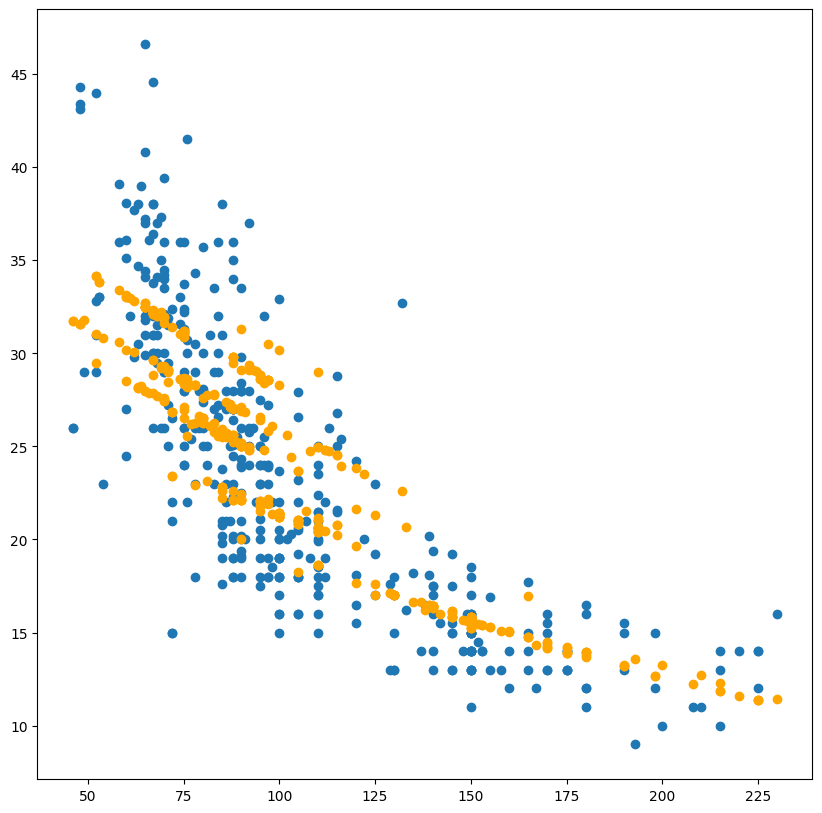

In [74]:
def plot(x, y, yhat, scaling=1):
   
    # compute model predictions
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(x, y, marker='o', linestyle='')
    ax.plot(x, yhat, marker='o', color='orange', linestyle='')

# plot some variables
plot(df['Horsepower'].to_numpy(), 
     df.Miles_per_Gallon.to_numpy(), 
     model.predict(df))